Warning: this notebook takes about an hour to run on a 2017 MacBook Pro, however the outputs have been saved

In [1]:
#Setting up notebook
%matplotlib notebook

In [2]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

#Import UFSS
import ufss

In [3]:
# these are helper functions defined in ufss for convenient forward and backward dft
# they use pyfftw
ift = ufss.signals.SignalProcessing.ift1D
ft = ufss.signals.SignalProcessing.ft1D

In [4]:
folder = 'v_3LS'

## Constructing the Liouvillian

In [5]:
# "v" 3LS from Smallwood 2017 paper

# the first step is to create a directory to work in
folder = 'v_3LS'
os.makedirs(folder,exist_ok=True)

# next we construct L0 based upon Smallwood et al.'s 2017 paper
# we are considering their v 3 level system (see their Figure 3)
# since this consists of 3 energy levels, we construct three occupation operators:
#Ground state:
n0 = np.zeros((3,3))
n0[0,0] = 1
#first excited state:
n1 = np.zeros((3,3))
n1[1,1] = 1
#second excited state:
n2 = np.zeros((3,3))
n2[2,2] = 1

# the Hamiltonian is given as
c = 0 #optical gap, which is rotated away
H = n0*0 + n1*(c-0.5) + n2*(c+0.5)
II = np.eye(H.shape[0]) #Identity of same dimension as H

Using H we construct the Liouvillian due to the closed system evolution given by
$\dot{\rho}=-\frac{i}{\hbar}\left[H,\rho\right]$, with $\hbar=1$, which can be written as
$$\dot{\rho}=-iH\rho\mathbb{1} + i\mathbb{1}\rho H$$
We turn this into a matrix using the following convention $A\rho B \rightarrow (A\otimes B^T)|\rho\rangle\rangle$
where $\rho$ is an $N\times N$ matrix and $|\rho\rangle\rangle$ is an $N^2$ length vector.  The transpose of the operator acting on the bra-side comes from the fact that we are flattening the matrix rho into a vector by taking each row, turning it into a column, and stacking those new columns ontop of each other (this is called C-contiguous ordering according to numpy's documentation)

In [6]:
L_closed = -1j*np.kron(H,II.T) + 1j*np.kron(II,H.T)

The next step is to add coupling to the bath.  To do this, we need to define pulse shapes used by Smallwood et al.'s paper, since they define the bath coupling in terms of the bandwidth of the pulses

In [7]:
#Smallwood's paper uses the following definition of the pulse shape
def g(t,sigma):
    """t is time.  Gaussian pulse, with time-domain standard deviation sigma, normalized to behave like
    a delta function as sigma -> 0"""
    pre = 1/(np.sqrt(2*np.pi)*sigma)
    return pre * np.exp(-t**2/(2*sigma**2))

def G(w,sigma):
    """w is angular frequency.  Analytical Fourier transform of g(t,sigma), where sigma is the time-domain 
    standard deviation sigma"""
    return np.exp(-w**2*sigma**2/2)

#Where they define the frequency bandwidth beta as
def beta(sigma):
    """Bandwidth of the pulse (for a Gaussian, this is the frequency-domain standard deviation)"""
    return 1/sigma

In [8]:
#They work with sigma = 1, and define the bath coupling relative to the bandwidth of the pulse:
sigma = 1
gamma_dephasing = 0.2*beta(sigma)
gamma_decay = 0.1*beta(sigma)

# Now let's add the bath coupling as described in the paper.  This is a 9x9 matrix with mostly zeros.
R = np.zeros(L_closed.shape)
# Because they are not keeping track of where lost population goes, R will be entirely diagonal
# They use two rates, a dephasing rate, and a population decay rate
R[1,1] = gamma_dephasing
R[2,2] = gamma_dephasing
R[3,3] = gamma_dephasing
R[4,4] = gamma_decay
R[5,5] = gamma_decay
R[6,6] = gamma_dephasing
R[7,7] = gamma_decay
R[8,8] = gamma_decay

In [9]:
#The total Liouvillian is therefore
L0 = L_closed - R

In order to describe the light-matter interaction, we need to write down the dipole operator.  Smallwood et al. take thee dipole transition from ground to each of the excited states to be 1.  We label the lower energy state 'a' and the other state 'b'.

In [10]:
mu_ag = np.zeros((3,3))
mu_ag[1,0] = 1
mu_ga = mu_ag.T

mu_bg = np.zeros((3,3))
mu_bg[2,0] = 1
mu_gb = mu_bg.T
# The total dipole operator
mu = mu_ag + mu_ga + mu_bg + mu_gb
# In order to enforce the rotating wave approximation (RWA) we only use mu_up and mu_down = mu_up.T
mu_ket_up = mu_ag + mu_bg
print(mu_ket_up)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


Now that we have L0 and mu_ket_up, we can pass this on to the UFSS class ManualL, which allows a user to input an arbitrary L0 and mu_up.  This class then diagonalizes L0, and saves mu as an operator on $|\rho\rangle\rangle$ in the diagonalized basis.

In [12]:
manL = ufss.HLG.ManualL(L0,mu_ket_up,savedir=folder,output='uf2')

Alternatively we can use the same class to save L0 and mu_ket_up in the format expected by RKE.  The only non-trivial operation being done here is to transform mu_ket_up (which is an operator on the Hilbert space of $H_0$) into $\mu^K_{up},\mu^K_{down},\mu^B_{up},\mu^B_{down}$, which all operate on the Liouvillian space of $L_0$.

In [13]:
manLRKE = ufss.HLG.ManualL(L0,mu_ket_up,savedir=folder,output='RKE')

## 2DPE

### Using UF$^2$ to calculate 2DPE

In [14]:
#re is short for rephasing 2DPE
re = ufss.DensityMatrices(os.path.join(folder,'uf2'),detection_type='complex_polarization')

In [15]:
# defining the optical pulses in the RWA
M = 25 # number of points used to resolve optical pulses
Delta = 6 # pulse interval
t = np.linspace(-Delta/2,Delta/2,num=M)
dt = t[1] - t[0]
ef = g(t,sigma)

# Smallwood et al. use a delta function for the local oscillator
lo_dt = 0.25 #### This must never change, because it defines t and tau, by default
lo_t =  np.arange(-5,5.2,lo_dt)    
lo_dt = lo_t[1] - lo_t[0]
lo = np.zeros(lo_t.size,dtype='float')
lo[lo.size//2] = 1/lo_dt


re.set_polarization_sequence(['x','x','x','x'])

re.set_efields([t,t,t,lo_t],[ef,ef,ef,lo],[0,0,0,0],[(0,1),(1,0),(1,0)])

re.gamma_res = 20
re.set_t(gamma_dephasing) #set tmax for polarization (only thing here that I think is opaque)
re.pulse_times = [0,0,0]

tau = re.t.copy() #dtau is the same as the dt for local oscillator
T = np.arange(0,1,1)
re.set_pulse_delays([tau,T])

The following cell will compute the full signal, including all overlap diagrams.  However, that is not what we want here, since Smallwood et al.'s formulas are only for the standard time-ordered diagrams

In [16]:
full_sig = re.calculate_signal_all_delays()

### Using Diagram Generator to find the time-ordered diagrams
(Note this makes Figure 2)

To get only the time-ordered diagrams, we need to do a little work: either write them down ourselves, or use UFSS's diagram generator to make them for us, as follows:

In [17]:
da = ufss.DiagramGenerator()

In [18]:
#set the times for which the electric fields are non-zero
da.efield_times = [t,t,t,lo_t]
#sete the phase-matching condition
da.set_phase_discrimination([(0,1),(1,0),(1,0)])
#Now input delay times for which the pulses are definitely not overlapping
time_ordered_diagrams = da.get_diagrams([0,100,200,200])
# Here they are in the format UFSS uses
print(time_ordered_diagrams)

[(('Bu', 0), ('Ku', 1), ('Ku', 2)), (('Bu', 0), ('Ku', 1), ('Bd', 2)), (('Bu', 0), ('Bd', 1), ('Ku', 2))]


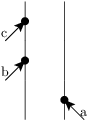

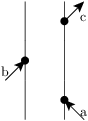

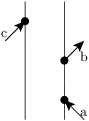

In [19]:
# Let's take a look visually to make sure these are the three diagrams we wanted
da.display_diagrams(time_ordered_diagrams)

In [20]:
# We can save the diagrams as individual pdf files as well
da.save_diagrams(time_ordered_diagrams,folder_name=os.path.join(folder,'time-ordered-diagrams/'))

With these diagrams at our disposal, we can now calculate the time-ordered signal, in order to compare to 
Smallwood et al.

In [21]:
sig = re.calculate_diagrams_all_delays(time_ordered_diagrams)
wtau, sig_ft = ift(tau,sig,zero_DC=False,axis=0)

In [22]:
print(sig_ft.shape)

(801, 1, 801)


<IPython.core.display.Javascript object>


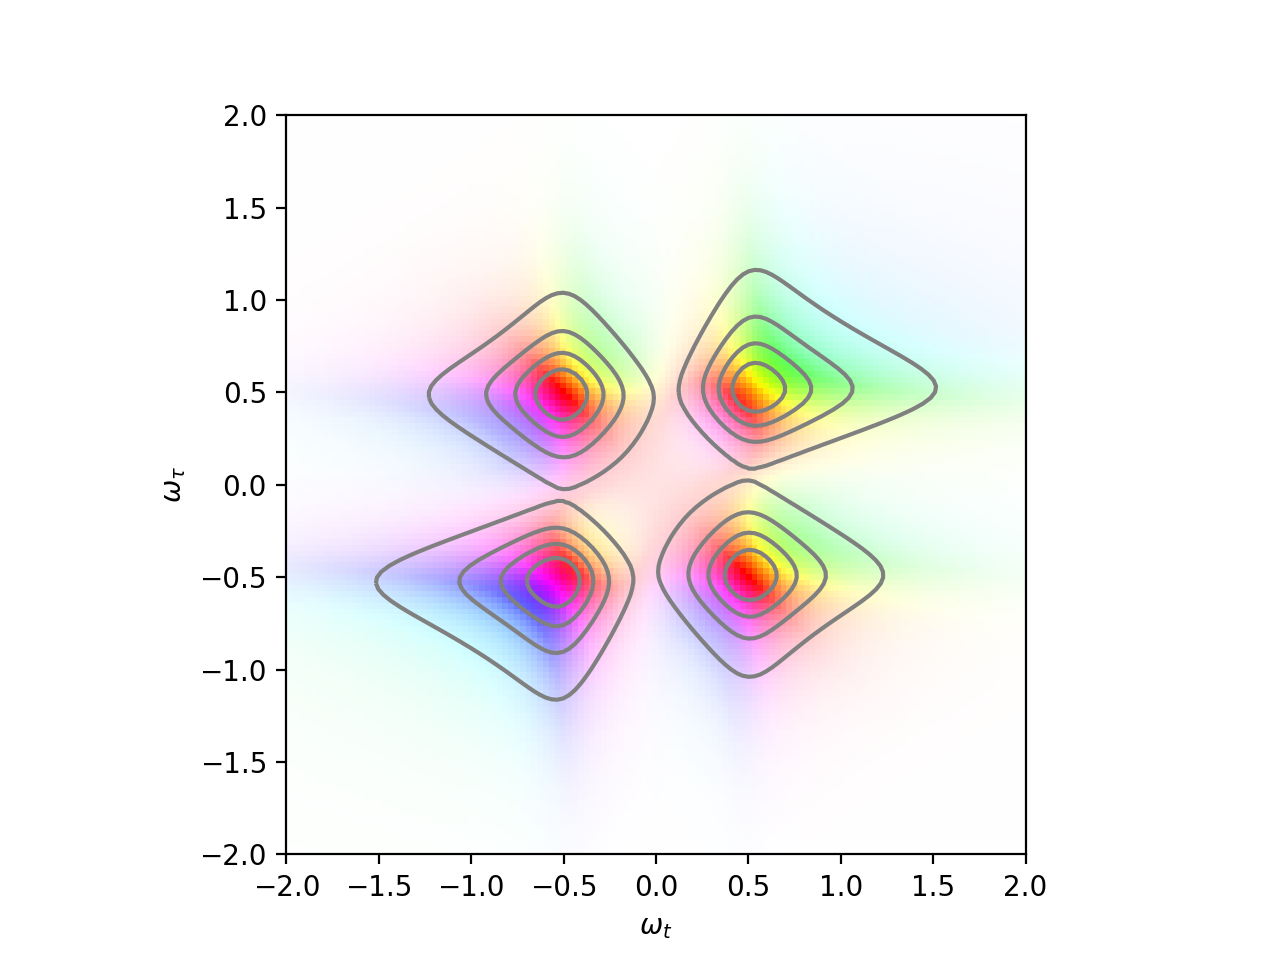

None


Text(0, 0.5, '$\\omega_\\tau$')

In [23]:
ufss.signals.plot2D(re.w,wtau,sig_ft[:,0,:].T,contour_levels=[0.2,0.4,0.6,0.8],contour_colormap=None,
                    contour_colors='gray',colorbar=False)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('$\omega_t$')
plt.ylabel('$\omega_\\tau$')

### Calculating signal using analytical solutions

Analytical signal: taken from "Analytical solutions to the finite-pulse Bloch model for multidimensional coherent spectroscopy" by Smallwood et al. (https://doi.org/10.1364/JOSAB.34.000419).

We start with their Eq. (18) for their definition of $P_{ij}$

In [23]:
def Pij(w,Wij):
    return 1j/(w-Wij)

And then their definition for $D_\alpha$

In [24]:
from scipy.special import erf

def Da(wt,T,wtau,eta,Wjk,Whi,Wfg,mu,sigma):
    wt = wt[:,np.newaxis,np.newaxis]
    T = T[np.newaxis,:,np.newaxis]
    wtau = wtau[np.newaxis,np.newaxis,:]
    pre = 1j*mu[2] * mu[1] * mu[0] / (2*np.pi) #Note we are using a different normalization factor
    wt_terms = Pij(wt,Wjk) * G(wt-eta[2]*c-Whi,sigma)
    wtau_terms = Pij(wtau,Wfg) * G(wtau-eta[0]*c,sigma) * G(wtau+eta[1]*c-Whi,sigma)
    T_terms = np.exp(-1j*Whi*T)
    mixed = 0.5*(1+erf((T+1j*sigma**2*(wt+wtau-eta[2]*c+eta[1]*c-2*Whi))/(2*sigma)))
    return pre*wt_terms*wtau_terms*T_terms*mixed

In [25]:
# We will be using
eta = [-1,1,1]
# which refers to the phase-matching direction -k1 + k2 + k3
# We will be using
mu = [1,1,1]
# because all dipole transitions have equal strength in this model

To calculate the signal using their model, we must sum over all pathways $\alpha$: 
$$\sum_\alpha D_\alpha$$
The pathways are a set of transitions, for which we need each dipole moment (trivially 1 for all transitions in this case) and the eigenvalue of $L_0$ of each step along the way.  Since $L_0$ is already diagonal in this case, we can get the eigenvalues from the diagonal of $L_0$.  UFSS uses 
$$\dot{\rho}=L_0\rho,$$
whereas Smallwood et al. are effectively using
$$\dot{\rho}=-i L_0\rho,$$
and so we will divide by $-i$ to find a

In [26]:
# L0 is diagonal, so the eigenvalues are trivially found to be
eigvals = L0.diagonal()/-1j
print(eigvals)

[-0. -0.j   0.5-0.2j -0.5-0.2j -0.5-0.2j -0. -0.1j -1. -0.1j  0.5-0.2j
  1. -0.1j -0. -0.1j]


Wheree the real part of the eigenvalues shows the frequency differences $\omega_i-\omega_j$ of the eigenvalues of $H_0$, and the imaginary part shows the decay rates.  We reshape this into a 3x3 matrix $W_{ij}$

In [27]:
W = eigvals.reshape((3,3))
print(W)

[[-0. -0.j   0.5-0.2j -0.5-0.2j]
 [-0.5-0.2j -0. -0.1j -1. -0.1j]
 [ 0.5-0.2j  1. -0.1j -0. -0.1j]]


In [28]:
# Now we're ready to calculate the analytical signal
wt = re.w
c = 0
analytical_sig = -1j * (Da(wt+c,T,wtau-c,eta,W[1,0],W[1,1],W[0,1],mu,sigma)
                        + Da(wt+c,T,wtau-c,eta,W[1,0],W[1,2],W[0,2],mu,sigma)
                        + Da(wt+c,T,wtau-c,eta,W[2,0],W[2,2],W[0,2],mu,sigma)
                        + Da(wt+c,T,wtau-c,eta,W[2,0],W[2,1],W[0,1],mu,sigma)
                        + Da(wt+c,T,wtau-c,eta,W[2,0],W[0,0],W[0,1],mu,sigma)
                        + Da(wt+c,T,wtau-c,eta,W[2,0],W[0,0],W[0,2],mu,sigma)
                        + Da(wt+c,T,wtau-c,eta,W[1,0],W[0,0],W[0,2],mu,sigma)
                        + Da(wt+c,T,wtau-c,eta,W[1,0],W[0,0],W[0,1],mu,sigma) )

<IPython.core.display.Javascript object>


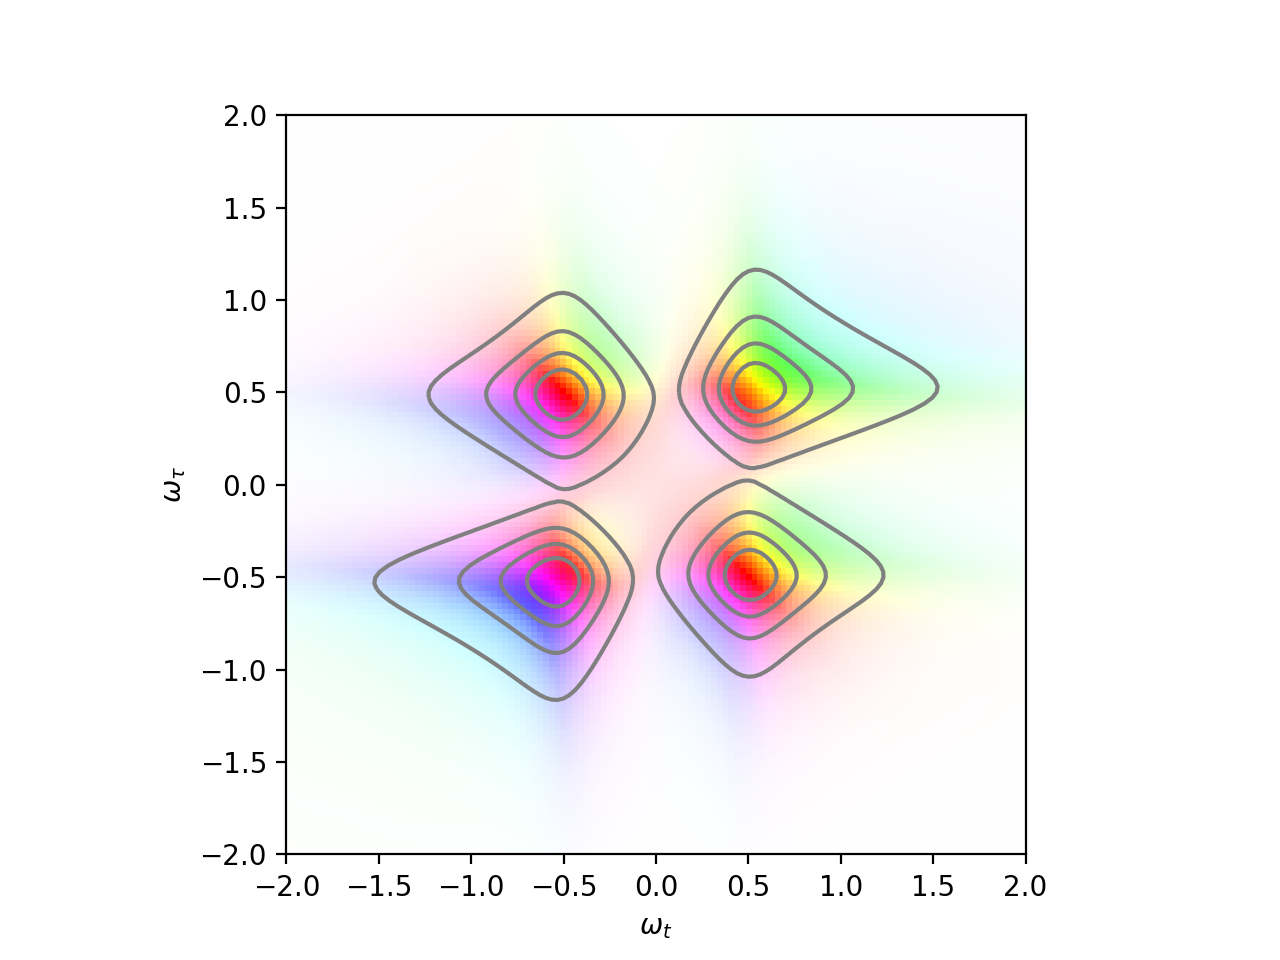

None


Text(0, 0.5, '$\\omega_\\tau$')

In [29]:
ufss.signals.plot2D(wt,wtau,analytical_sig[:,0,:],contour_levels=[0.2,0.4,0.6,0.8],contour_colormap=None,
                    contour_colors='gray',colorbar=False)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('$\omega_t$')
plt.ylabel('$\omega_\\tau$')

### Comparing UF$^2$ to analytical solutions

In [30]:
def L2_norm(a,b):
    """Computes L2 norm of two nd-arrays, taking the b as the reference"""
    return np.sqrt(np.sum(np.abs(a-b)**2)/np.sum(np.abs(b)**2))

L2 norm difference of UF2 to analytical 0.006993939731709094


<IPython.core.display.Javascript object>


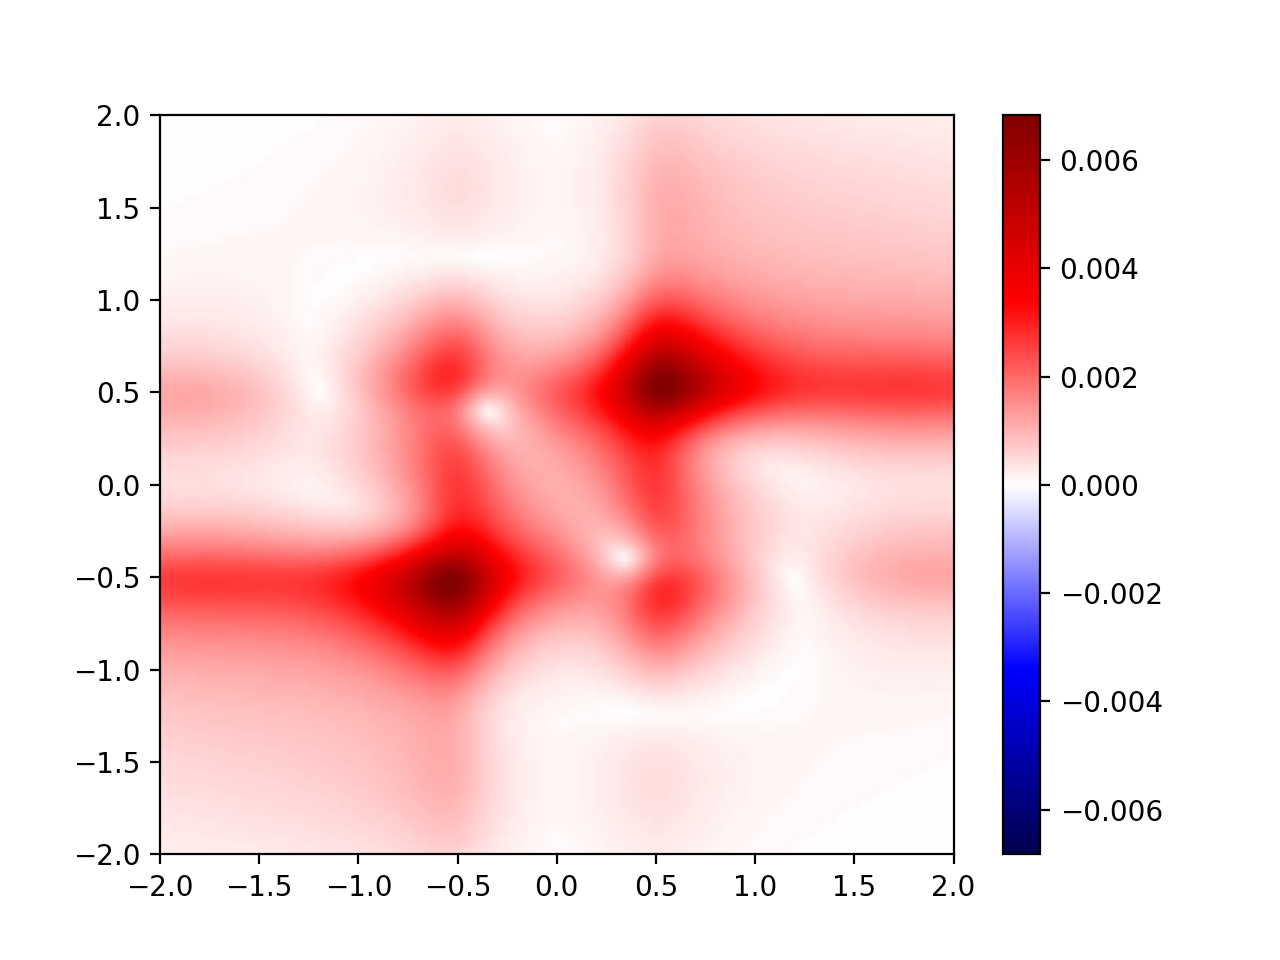

(-2, 2)

In [31]:
print('L2 norm difference of UF2 to analytical',L2_norm(sig_ft[:,0,:].T,analytical_sig[:,0,:]))
ufss.signals.plot2D(wt,wtau,sig_ft[:,0,:].T-analytical_sig[:,0,:],part='abs',
                    norm=np.max(np.abs(analytical_sig[:,0,:])))
plt.xlim([-2,2])
plt.ylim([-2,2])

In [33]:
def change_efields(dt,tmax):
    n = round(tmax/dt)
    t = np.arange(-n,n+1/2,1)*dt*sigma
    dt = t[1] - t[0]
    tmax = t[-1]
    ef = g(t,sigma)
    
    lo_n = round(tmax/lo_dt)
    lo_t = np.arange(-5,5+lo_dt/2,lo_dt)*sigma
    lo = np.zeros(lo_t.size,dtype='float')
    lo[lo.size//2] = 1/lo_dt

    re.set_polarization_sequence(['x','x','x','x'])
    re.set_efields([t,t,t,lo_t],[ef,ef,ef,lo],[0,0,0,0],['-','+','+'])
    return dt,tmax
    
def calculate_rephasing_spectrum(taus,Ts):
    sig = re.calculate_diagrams_all_delays(time_ordered_diagrams)

    #Take fourier transform along tau axis (this uses a helper function that gets the normalization and shift(s) right)
    wtau, sig_ft = ift(tau,sig,zero_DC=False,axis=0)
    return sig_ft

In [ ]:
dts = np.logspace(-3,0,num=26)*sigma
tmaxes = np.arange(2,7,1)*sigma
signals = np.zeros((dts.size,tmaxes.size,re.w.size,tau.size),dtype='complex')
Ms = np.zeros((dts.size,tmaxes.size))
diffs = np.zeros((dts.size,tmaxes.size))
for i in range(dts.size):
    for j in range(tmaxes.size):
        change_efields(dts[i],tmaxes[j])
        Ms[i,j] = re.efield_times[0].size
        signal = calculate_rephasing_spectrum(tau,T)
        signals[i,j,:,:] = signal[:,0,:].T
        diffs[i,j] = L2_norm(signals[i,j,...],analytical_sig[:,0,:])

In [ ]:
def midpoints_to_edges(x_arr):
    if x_arr[0] < x_arr[-1]:
        flip = False
    else:
        flip = True
        x_arr = x_arr[::-1]
    new_x_arr = np.zeros(x_arr.size+1)
    dx = x_arr[1] - x_arr[0]
    new_x_arr[:-1] = x_arr - dx/2
    new_x_arr[-1] = new_x_arr[-2] + dx
    if flip:
        new_x_arr = new_x_arr[::-1]
    return new_x_arr

def log_midpoints_to_edges(x_arr):
    if x_arr[0] < x_arr[-1]:
        flip = False
    else:
        flip = True
        x_arr = x_arr[::-1]
    xa = x_arr[0]
    xb = x_arr[-1]
    n = x_arr.size
    exp_a = np.log10(xa)
    exp_b = np.log10(xb)
    exp_dt = np.log10(x_arr[1]) - np.log10(x_arr[0])
    new_x_arr = np.logspace(exp_a-exp_dt/2,exp_b+exp_dt/2,num=n+1)
    if flip:
        new_x_arr = new_x_arr[::-1]
    return new_x_arr

#### Making Figure 4

<IPython.core.display.Javascript object>


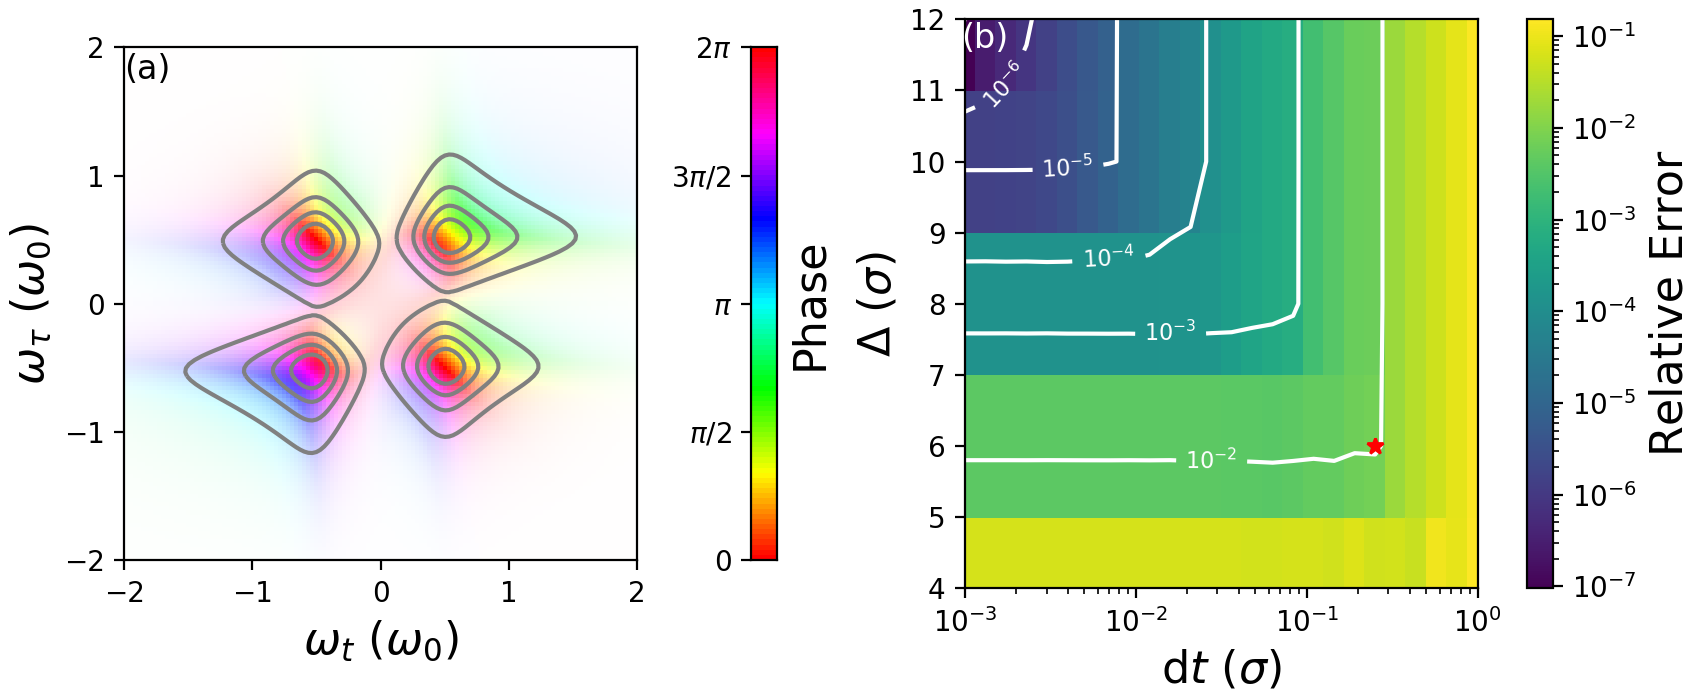

None
None


In [37]:
#4(a)
fig = plt.figure(constrained_layout=True,figsize=(8.5,3.5))
widths = [2, 0.1,2, 0.1]
heights = [2]
spec = fig.add_gridspec(ncols=len(widths), nrows=1, width_ratios=widths,
                          height_ratios=heights)

axes = []
for row in range(1):
    for col in range(len(widths)):
        ax = fig.add_subplot(spec[row, col])
        axes.append(ax)
        
ax0,ax0cb, ax1,ax2 = axes

ufss.signals.plot2D(wt,wtau,analytical_sig[:,0,:],contour_levels=[0.2,0.4,0.6,0.8],contour_colormap=None,
                    contour_colors='gray',fig=fig,ax=ax0,part='complex',colorbar=False)
ax0.set_xlim([-2,2])
ax0.set_ylim([-2,2])
ax0.set_yticks([-2,-1,0,1,2])
ax0.set_xlabel('$\omega_t$ ($\omega_0$)',fontsize=16)
ax0.set_ylabel('$\omega_\\tau$ ($\omega_0$)',fontsize=16)
ax0.text(-2,1.75,'(a)',fontsize=12)

r = np.array([0,2*np.pi/20])
th = np.linspace(0,1,num=100,endpoint=True)*2*np.pi
z = np.array([1,1,1,1,1,1])[:,np.newaxis]*np.exp(1j*th[np.newaxis,:])
ufss.signals.plot2D(r,th,z,contour_levels=None,contour_colormap=None,
                    fig=fig,ax=ax0cb,part='complex',colorbar=False)
ax0cb.set_xticks([])
ax0cb.set_yticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi])
ax0cb.set_yticklabels(['0','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'])
ax0cb.set_ylabel('Phase',fontsize=16)
ax0cb.yaxis.set_label_position("right")


#######
#4(b)

X,Y = np.meshgrid(log_midpoints_to_edges(dts),midpoints_to_edges(2*tmaxes),indexing='ij')
Xcont,Ycont = np.meshgrid(dts,2*tmaxes,indexing='ij')
handle = ax1.pcolormesh(X,Y,diffs,norm=LogNorm(vmin=diffs.min(), vmax=diffs.max()),shading='flat')
cb = fig.colorbar(handle,cax=ax2)
cb.set_label('Relative Error',fontsize=16)
chandle = ax1.contour(Xcont,Ycont,diffs,levels=np.logspace(-7,-2,num=6),colors='w')
ax1.plot(0.25,2*3,'r*')
ax1.set_xscale('log')
ax1.set_xlabel('d$t$ ($\sigma$)',fontsize=16)
ax1.set_ylabel('$\Delta$ ($\sigma$)',fontsize=16)
ax1.text(0.00095,11.6,'(b)',fontsize=12,color='w')
ax1.set_ylim([4,12])
ax1.set_xlim([1E-3,1])

fmt = {}
lvl_strs = [r'$10^{-7}$',r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$']
for l,s in zip(chandle.levels,lvl_strs):
    fmt[l] = s

ax1.clabel(chandle,chandle.levels,fmt=fmt,fontsize=8)

#plt.tight_layout()
#fig.subplots_adjust(wspace=0.25)
fig.savefig(os.path.join(folder,'Smallwood2017_UF2Comparison.pdf'))